In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial
from scipy.interpolate import spline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import pickle
import tabulate
import wandb
from collections import namedtuple, defaultdict

import meta_learning_data_analysis as analysis
import meta_learning_analysis_plots as plots

In [4]:
np.set_printoptions(linewidth=160)
# Avoid escaping any latex characters
tabulate.LATEX_ESCAPE_RULES = {}

MIN_FONT_SIZE = 14
LABELS_FONT_SIZE = 20
TITLE_FONT_SIZE = 24

matplotlib.rcParams.update({'font.size': MIN_FONT_SIZE})
FONT_DICT = dict(fontsize=LABELS_FONT_SIZE) 
TITLE_FONT_DICT = dict(fontsize=TITLE_FONT_SIZE)

PER_PLOT_WIDTH = 6

QUERY_ORDINAL_POSITION_COMORLAP= 'cool'
NUM_TIMES_TRAINED_COLORMAP = 'copper'

In [5]:
cache = analysis.refresh_cache()
print(cache.keys())

six_replications_analyses = cache['six_replications_analyses']
simultaneous_training_analyses = cache['simultaneous_training_analyses']

dict_keys(['six_replications_analyses', 'control_analyses', 'query_mod_replications', 'six_replications_updated_analyses', 'updated_control_analyses', 'query_mod_updated_analyses', 'forgetting_curves_raw_data', 'preliminary_maml_analyses', 'baseline_maml_comparison_analyses', 'maml_analyses', 'maml_alpha_0_analyses', 'maml_meta_test_analyses', 'balanced_batches_analyses', 'baseline_total_curve_analyses', 'control_total_curve_analyses', 'query_mod_total_curve_analyses', 'simultaneous_training_analyses', 'per_task_simultaneous_training_analyses'])


-----

# First stab at plotting these

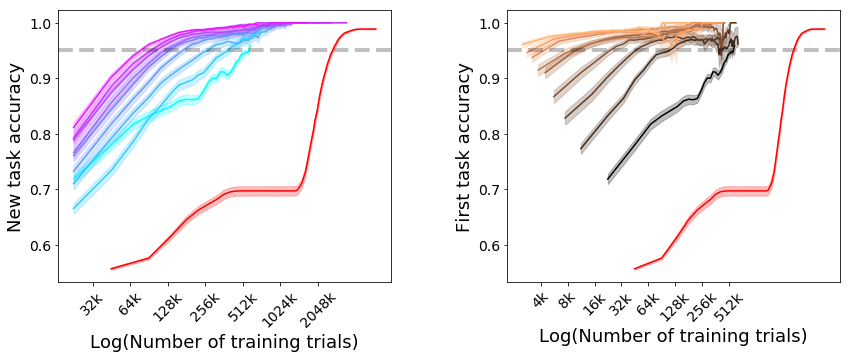

In [7]:
NROWS = 1
NCOLS = 2
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 10

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.35)


raw_accuracy_axes = (plt.subplot(NROWS, NCOLS, 1), plt.subplot(NROWS, NCOLS, 2))
plots.both_raw_accuracy_plots(six_replications_analyses, '',
                              shade_error=True, font_dict=multi_plot_font_dict, log_x=True,
                              new_task_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                              first_task_colormap=NUM_TIMES_TRAINED_COLORMAP, title_font_dict=title_font_dict,
                              hline_y=0.95, first_task_title='', new_task_title='', add_colorbars=False,
                              external_axes=raw_accuracy_axes)

# add the simultaneous training plots

TRIALS_PER_EPOCH = 45000

simultaneous_length = simultaneous_training_analyses.combined.mean.shape[0]
simultaneous_x = np.arange(1, simultaneous_length + 1) * TRIALS_PER_EPOCH
simultaneous_y = simultaneous_training_analyses.combined.mean
simultaneous_sem = simultaneous_training_analyses.combined.sem

for ax in raw_accuracy_axes:
    ax.plot(simultaneous_x, simultaneous_y, color='red')
    ax.fill_between(simultaneous_x, 
                    simultaneous_y - simultaneous_sem, 
                    simultaneous_y + simultaneous_sem,
                    color='red', alpha=0.25)
    

### This is looking ugly because I had to smooth over the dimensions

And each dimension, while not qualitatively different, takes vastly different amounts of time. To verify this, let's plot each dimension separately:

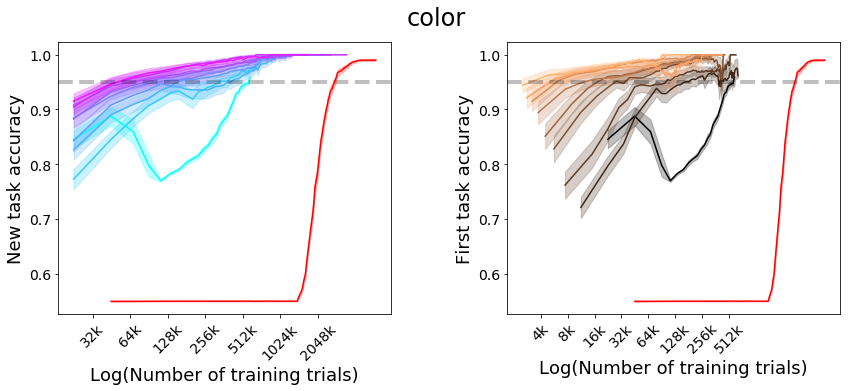

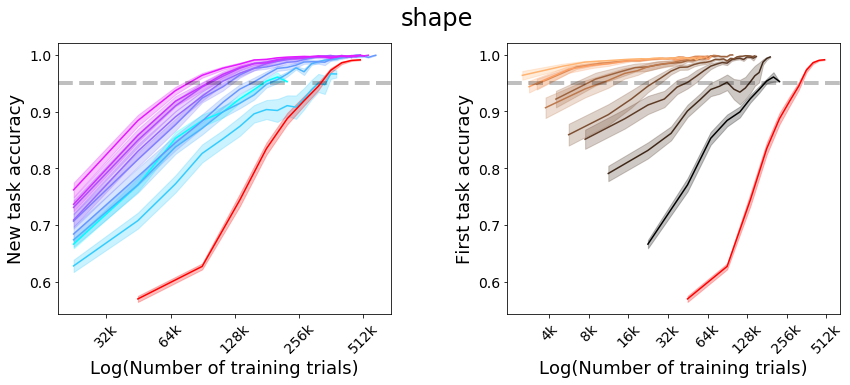

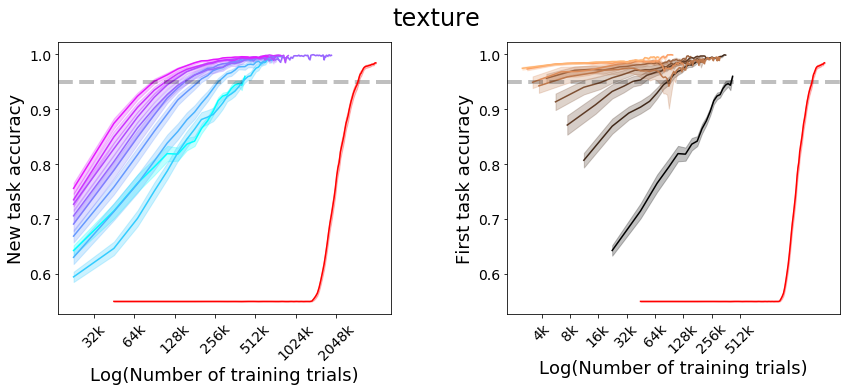

In [8]:
for dimension_index in range(3):
    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(hspace=0.4, wspace=0.35)
    figure.suptitle(analysis.DIMENSION_NAMES[dimension_index], **TITLE_FONT_DICT)

    raw_accuracy_axes = (plt.subplot(NROWS, NCOLS, 1), plt.subplot(NROWS, NCOLS, 2))
    plots.both_raw_accuracy_plots(six_replications_analyses, '', dimension_index=dimension_index,
                                  shade_error=True, font_dict=multi_plot_font_dict, log_x=True,
                                  new_task_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                  first_task_colormap=NUM_TIMES_TRAINED_COLORMAP, title_font_dict=title_font_dict,
                                  hline_y=0.95, first_task_title='', new_task_title='', add_colorbars=False,
                                  external_axes=raw_accuracy_axes, plot_consecutive=False)

    # add the simultaneous training plots

    TRIALS_PER_EPOCH = 45000

    simultaneous_y = simultaneous_training_analyses[dimension_index].mean
    simultaneous_sem = simultaneous_training_analyses[dimension_index].sem
    
    simultaneous_length = simultaneous_y.shape[0]
    simultaneous_x = np.arange(1, simultaneous_length + 1) * TRIALS_PER_EPOCH

    for ax in raw_accuracy_axes:
        ax.plot(simultaneous_x, simultaneous_y, color='red')
        ax.fill_between(simultaneous_x, 
                        simultaneous_y - simultaneous_sem, 
                        simultaneous_y + simultaneous_sem,
                        color='red', alpha=0.25)

------

# What if we combine based on % to maximum?

/Users/guydavidson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


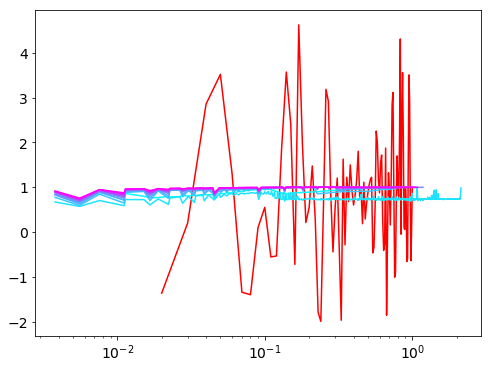

In [15]:
SEQUENTIAL_TRIALS_PER_EPOCH = 22500
SIMULTANEOUS_TRIALS_PER_EPOCH = 45000
N = 60

sequential_means = [defaultdict(list) for _ in range(10)]
sequential_sems = [defaultdict(list) for _ in range(10)]

simultaneous_means = defaultdict(list)
simultaneous_sems = defaultdict(list)

for dimension_index in range(3):
    sequential_mean = six_replications_analyses[dimension_index].new_task_accuracies.mean
    sequential_std = six_replications_analyses[dimension_index].new_task_accuracies.std
    sequential_length = sequential_mean.shape[1]
    sequential_x = np.arange(1, sequential_length + 1) * SEQUENTIAL_TRIALS_PER_EPOCH
    
    simultaneous_mean = simultaneous_training_analyses[dimension_index].mean
    simultaneous_sem = simultaneous_training_analyses[dimension_index].sem
    simultaneous_length = simultaneous_mean.shape[0]
    simultaneous_x = np.arange(1, simultaneous_length + 1) * SIMULTANEOUS_TRIALS_PER_EPOCH

    max_simultaneous_x = simultaneous_x[-1]
    simultaneous_x = simultaneous_x / max_simultaneous_x
    sequential_x = sequential_x / max_simultaneous_x

    for i, key in enumerate(simultaneous_x):
        simultaneous_means[key].append(simultaneous_mean[i])
        simultaneous_sems[key].append(simultaneous_sem[i])
    
    for task in range(10): 
        for i, key in enumerate(sequential_x):
            if np.isnan(sequential_mean[task, i]):
                break
                
            sequential_means[task][key].append(sequential_mean[task, i])
            sequential_sems[task][key].append(sequential_std[task, i] / N ** 0.5)
        
# Collate the results 

simultaneous_x, simultaneous_y = zip(*[(key, np.mean(simultaneous_means[key])) for key in sorted(simultaneous_means.keys())])
simultaneous_x = np.array(simultaneous_x)
simultaneous_y = np.array(simultaneous_y)
simultaneous_y_sem = np.array([np.sqrt(np.sum(simultaneous_sems[key])) / len(simultaneous_sems[key]) for key in sorted(simultaneous_sems.keys())])

sequential_xs = []
sequential_ys = []
sequential_y_sems = []

for task in range(10):
    seq_x, seq_y = zip(*[(key, np.mean(sequential_means[task][key])) for key in sorted(sequential_means[task].keys())])
    sequential_xs.append(np.array(seq_x))
    sequential_ys.append(np.array(seq_y))
    seq_y_sem = [np.sqrt(np.sum(sequential_sems[task][key])) / len(sequential_sems[task][key]) 
                 for key in sorted(sequential_sems[task].keys())]
    sequential_y_sems.append(np.array(seq_y_sem))
    

plt.figure(figsize=(8, 6))
cmap = plt.get_cmap(QUERY_ORDINAL_POSITION_COMORLAP)

# plt.plot(simultaneous_x, simultaneous_y, color='red')
# Let's try a spline:
spline_simul_x = np.linspace(0.02, 1, 99)
spline_simul_y = spline(simultaneous_x, simultaneous_y, spline_simul_x, order=4
                       )
plt.plot(spline_simul_x, spline_simul_y, color='red')

# plt.fill_between(simultaneous_x, simultaneous_y - simultaneous_y_sem, simultaneous_y + simultaneous_y_sem,
#                  color='red', alpha=0.25)

for task in range(10):
    seq_x = sequential_xs[task]
    seq_y = sequential_ys[task]
    seq_y_sem = sequential_y_sems[task]
    
    color = cmap(task / 9)
    plt.plot(seq_x, seq_y, color=color)
#     plt.fill_between(seq_x, seq_y - seq_y_sem, seq_y + seq_y_sem, color=color, alpha=0.25)

plt.semilogx()
plt.show()


In [ ]:
spline?

In [ ]:
dimension_index = 1
print(six_replications_analyses[dimension_index].new_task_accuracies.mean.shape)
print(simultaneous_training_analyses[dimension_index].mean.shape)

----

# What if we plot the tasks consecutively?

Does it make any more sense?

In [ ]:
for dimension_index in range(3):
    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(hspace=0.4, wspace=0.35)
    figure.suptitle(analysis.DIMENSION_NAMES[dimension_index], **TITLE_FONT_DICT)

    raw_accuracy_axes = (plt.subplot(NROWS, NCOLS, 1), plt.subplot(NROWS, NCOLS, 2))
    plots.both_raw_accuracy_plots(six_replications_analyses, '', dimension_index=dimension_index,
                                  shade_error=True, font_dict=multi_plot_font_dict, log_x=True,
                                  new_task_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                  first_task_colormap=NUM_TIMES_TRAINED_COLORMAP, title_font_dict=title_font_dict,
                                  hline_y=0.95, first_task_title='', new_task_title='', add_colorbars=False,
                                  external_axes=raw_accuracy_axes, plot_consecutive=True)

    # add the simultaneous training plots

    TRIALS_PER_EPOCH = 45000

    simultaneous_length = simultaneous_training_analyses[dimension_index].mean.shape[0]
    simultaneous_x = np.arange(1, simultaneous_length + 1) * TRIALS_PER_EPOCH
    simultaneous_y = simultaneous_training_analyses[dimension_index].mean
    simultaneous_sem = simultaneous_training_analyses[dimension_index].sem

    for ax in raw_accuracy_axes:
        ax.plot(simultaneous_x, simultaneous_y, color='red')
        ax.fill_between(simultaneous_x, 
                        simultaneous_y - simultaneous_sem, 
                        simultaneous_y + simultaneous_sem,
                        color='red', alpha=0.25)

----

# Scratch

In [ ]:
simultaneous_training_analyses.combined.mean.shape